### Predictive Analysis of Coffee Shop Sales

#### 1. Project Overview and Objectives

- This project aims to analyze a dataset to assess product profitability. Objectives include
cleaning the data, conducting profit and loss analysis, and using predictive modeling to
forecast future profits. Key tasks are:        
 
**Data Cleaning:** Address inconsistencies and missing values.          
**Profit/Loss Analysis:** Identify profitable and loss-making products/services.                 
**Profit Prediction:** Forecast future profits and explore profitability factors.                 
**Loss Mitigation:** Develop strategies to address and convert loss-making products.               

#### 2. Data Preprocessing

##### 2.1 Import Libraries

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import statsmodels.api as sm
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##### 2.2 Read and Explore Data

In [12]:
df = pd.read_excel('Coffee Shop Sales.xlsx')
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [13]:
df.columns

Index(['transaction_id', 'transaction_date', 'transaction_time',
       'transaction_qty', 'store_id', 'store_location', 'product_id',
       'unit_price', 'product_category', 'product_type', 'product_detail'],
      dtype='object')

In [14]:
df.shape

(149116, 11)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [16]:
df.describe()

,transaction_id,transaction_date,transaction_qty,store_id,product_id,unit_price
count,149116.000000,149116,149116.000000,149116.000000,149116.000000,149116.000000
mean,74737.371872,2023-04-15 11:50:32.173609984,1.438276,5.342063,47.918607,3.382219
min,1.000000,2023-01-01 00:00:00,1.000000,3.000000,1.000000,0.800000
25%,37335.750000,2023-03-06 00:00:00,1.000000,3.000000,33.000000,2.500000
50%,74727.500000,2023-04-24 00:00:00,1.000000,5.000000,47.000000,3.000000
75%,112094.250000,2023-05-30 00:00:00,2.000000,8.000000,60.000000,3.750000
max,149456.000000,2023-06-30 00:00:00,8.000000,8.000000,87.000000,45.000000
std,43153.600016,NaN,0.542509,2.074241,17.930020,2.658723


In [17]:
df.describe(include = 'object')

,transaction_time,store_location,product_category,product_type,product_detail
count,149116,149116,149116,149116,149116
unique,25762,3,9,29,80
top,09:31:15,Hell's Kitchen,Coffee,Brewed Chai tea,Chocolate Croissant
freq,41,50735,58416,17183,3076


##### 2.3 Data Cleaning

2.3.1 Data Convertion
- Convert transaction_time Column to datetime Format


In [18]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time

- Convert store_id and product_id to object

In [19]:
df['store_id'] = df['store_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)

2.3.2 Remove Duplicate Data
- Identify and remove any duplicate rows in the dataset to ensure data integrity.


In [20]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
df_cleaned = df.drop_duplicates() 
print("Shape of DataFrame after removing duplicates:", df_cleaned.shape)

Number of duplicate rows: 0
Shape of DataFrame after removing duplicates: (149116, 11)


2.3.3 Handle Missing Values
- Identify and handle missing values in the dataset .

In [21]:
missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).round(2)
missing_percentage

transaction_id      0.0
transaction_date    0.0
transaction_time    0.0
transaction_qty     0.0
store_id            0.0
store_location      0.0
product_id          0.0
unit_price          0.0
product_category    0.0
product_type        0.0
product_detail      0.0
dtype: float64

2.3.4 Handling Inconsistencies
- Standardize Categorical Data:


In [22]:
df_cleaned['product_category'] = df_cleaned['product_category'].str.lower().str.strip()
df_cleaned['store_location'] = df_cleaned['store_location'].str.lower().str.strip()
df_cleaned['product_type'] = df_cleaned['product_type'].str.lower().str.strip()
df_cleaned['product_detail'] = df_cleaned['product_detail'].str.lower().str.strip()

In [23]:
df_cleaned.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,lower manhattan,32,3.0,coffee,gourmet brewed coffee,ethiopia rg
1,2,2023-01-01,07:08:56,2,5,lower manhattan,57,3.1,tea,brewed chai tea,spicy eye opener chai lg
2,3,2023-01-01,07:14:04,2,5,lower manhattan,59,4.5,drinking chocolate,hot chocolate,dark chocolate lg
3,4,2023-01-01,07:20:24,1,5,lower manhattan,22,2.0,coffee,drip coffee,our old time diner blend sm
4,5,2023-01-01,07:22:41,2,5,lower manhattan,57,3.1,tea,brewed chai tea,spicy eye opener chai lg


#### 3. Profit/Loss Analysis

##### 3.1 Visualize Revenue by Store Location
- A pie chart illustrating the total revenue generated by each store location

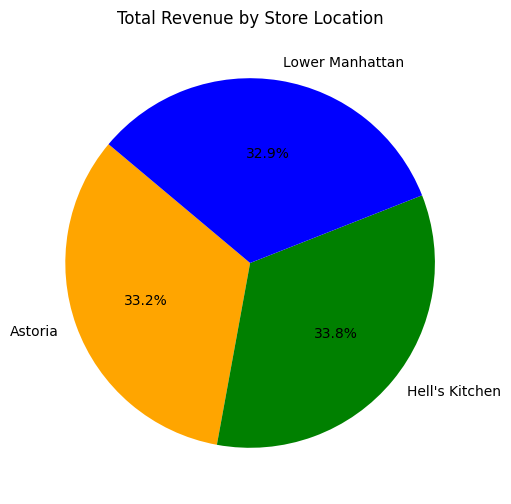

In [24]:
df['revenue'] = df['transaction_qty'] * df['unit_price']
revenue_by_location = df.groupby('store_location')['revenue'].sum().reset_index()
colors = ['orange', 'green', 'blue', 'red', 'purple', 'yellow', 'cyan'] 
plt.figure(figsize=(10, 6))
plt.pie(revenue_by_location['revenue'],
 labels=revenue_by_location['store_location'],
 autopct='%1.1f%%',
 colors=colors,
 startangle=140)
plt.title('Total Revenue by Store Location')
plt.show()

##### 3.2 Calculate Revenue by Product Category
- The total revenue generated by each product category is computed to analyze
category-wise performance.


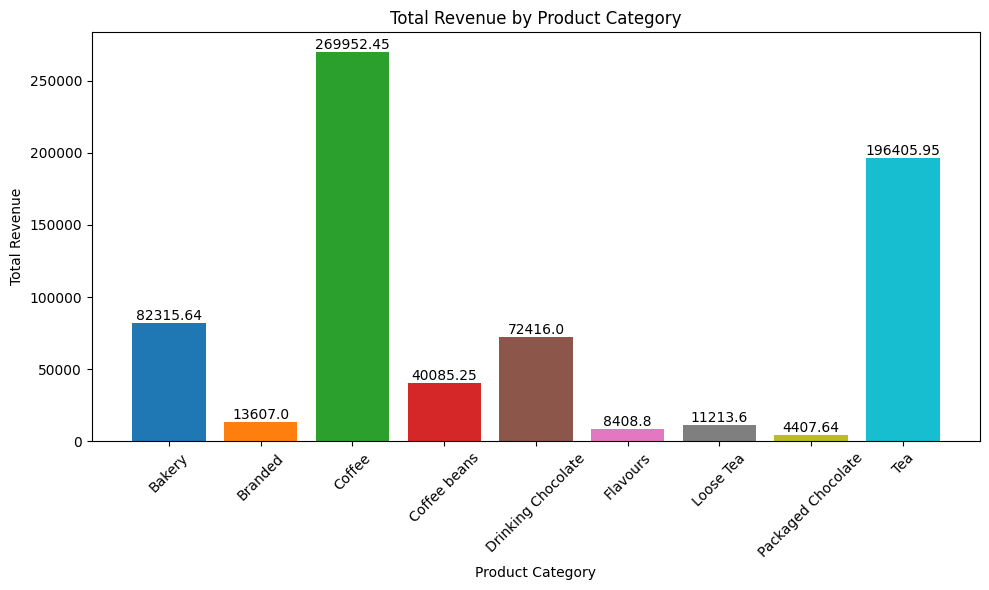

In [25]:
df['revenue'] = df['transaction_qty'] * df['unit_price']
revenue_by_category = df.groupby('product_category')['revenue'].sum().reset_index()
colors = plt.cm.tab10(np.linspace(0, 1, len(revenue_by_category)))
plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_by_category['product_category'], revenue_by_category['revenue'], color=colors)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 3.3 Visualize Revenue by Product Detail
- top 10 and bottom 10 products based on revenue to illustrate significant contributors
and underperformers.


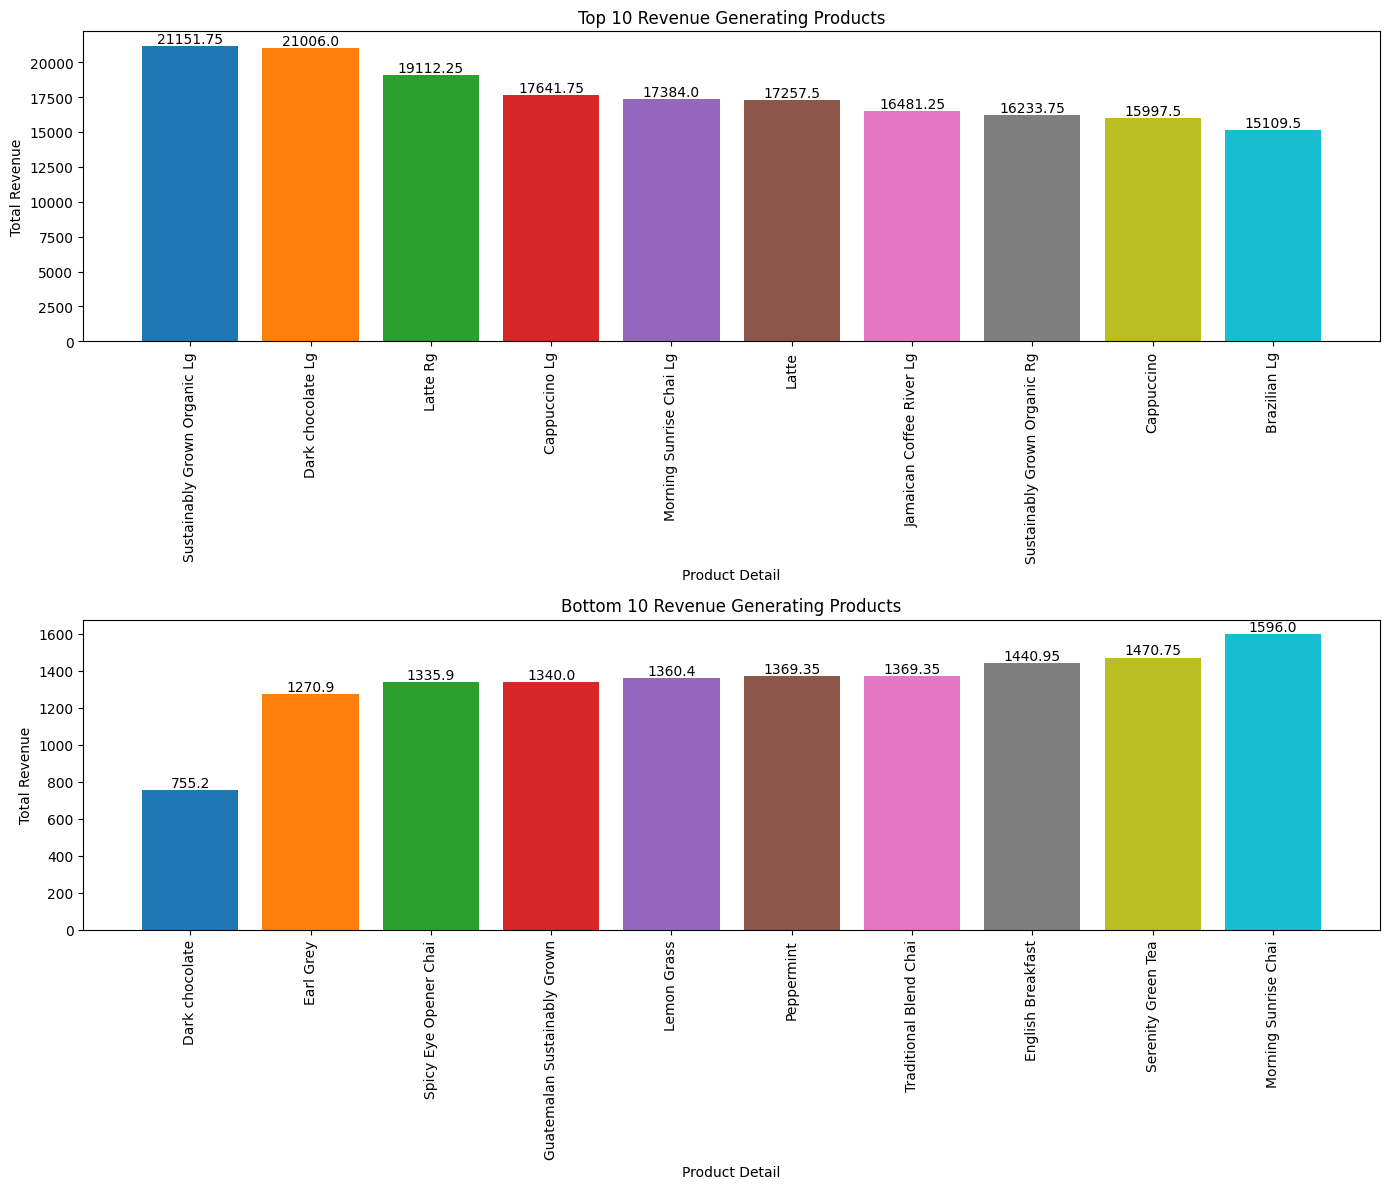

In [26]:
revenue_by_product = df.groupby('product_detail')['revenue'].sum().reset_index()
top_revenue_products = revenue_by_product.sort_values(by='revenue', ascending=False).head(10)
low_revenue_products = revenue_by_product.sort_values(by='revenue', ascending=True).head(10)
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
colors_top = plt.cm.tab10(np.linspace(0, 1, len(top_revenue_products)))
colors_low = plt.cm.tab10(np.linspace(0, 1, len(low_revenue_products)))
axes[0].bar(top_revenue_products['product_detail'], top_revenue_products['revenue'], color=colors_top)
axes[0].set_xlabel('Product Detail')
axes[0].set_ylabel('Total Revenue')
axes[0].set_title('Top 10 Revenue Generating Products')
axes[0].tick_params(axis='x', rotation=90)
for bar in axes[0].patches:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval, 2), ha='center', va='bottom')
    
axes[1].bar(low_revenue_products['product_detail'], low_revenue_products['revenue'], color=colors_low)
axes[1].set_xlabel('Product Detail')
axes[1].set_ylabel('Total Revenue')
axes[1].set_title('Bottom 10 Revenue Generating Products')
axes[1].tick_params(axis='x', rotation=90)
for bar in axes[1].patches:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### 3.4 Visualize Quantity Sold by Product Category
- total quantity sold for each product category, providing insight into the distribution of
sales volume across different categories.

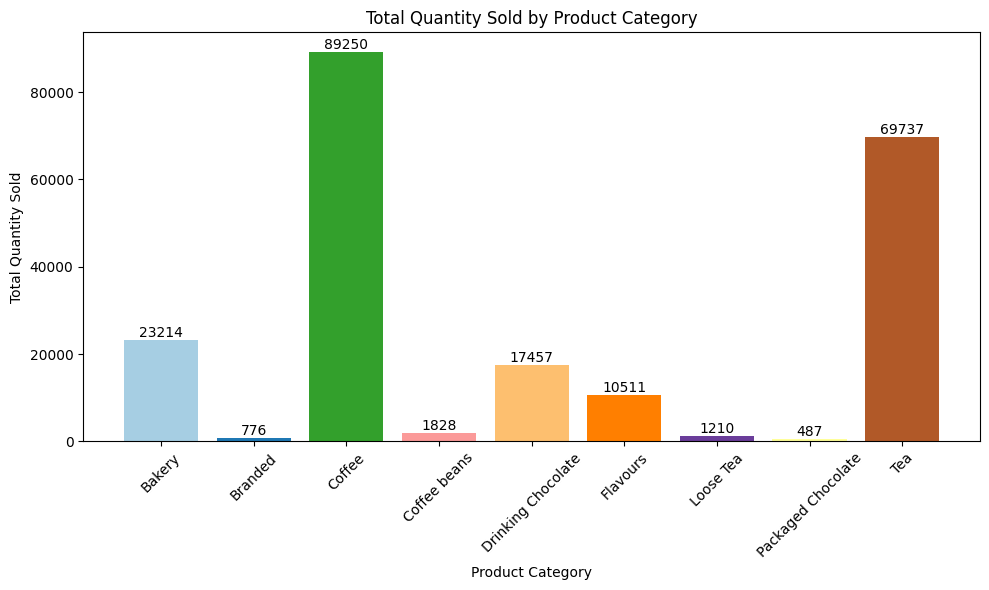

In [27]:
quantity_by_category = df.groupby('product_category')['transaction_qty'].sum().reset_index()

colors = plt.cm.Paired(np.linspace(0, 1, len(quantity_by_category)))

plt.figure(figsize=(10, 6))
bars = plt.bar(quantity_by_category['product_category'], quantity_by_category['transaction_qty'], color=colors)

plt.xlabel('Product Category')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Product Category')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### 3.5 Calculate Total Quantity Sold by Product
- total quantity sold for each product , highlighting key products with high and low sales
volumes.


In [28]:
quantity_by_product = df.groupby('product_detail')['transaction_qty'].sum().reset_index()
print(quantity_by_product)

                  product_detail  transaction_qty
0               Almond Croissant             1911
1            Brazilian - Organic              214
2                   Brazilian Lg             4317
3                   Brazilian Rg             4385
4                   Brazilian Sm             4310
..                           ...              ...
75  Sustainably Grown Organic Lg             4453
76  Sustainably Grown Organic Rg             4329
77        Traditional Blend Chai              153
78     Traditional Blend Chai Lg             4174
79     Traditional Blend Chai Rg             4512

[80 rows x 2 columns]


##### 3.6 Visualize High and Low Quantity Sold Products
- top 10 and bottom 10 products based on quantity sold, offering insights into the most
and least popular items in terms of sales volume.


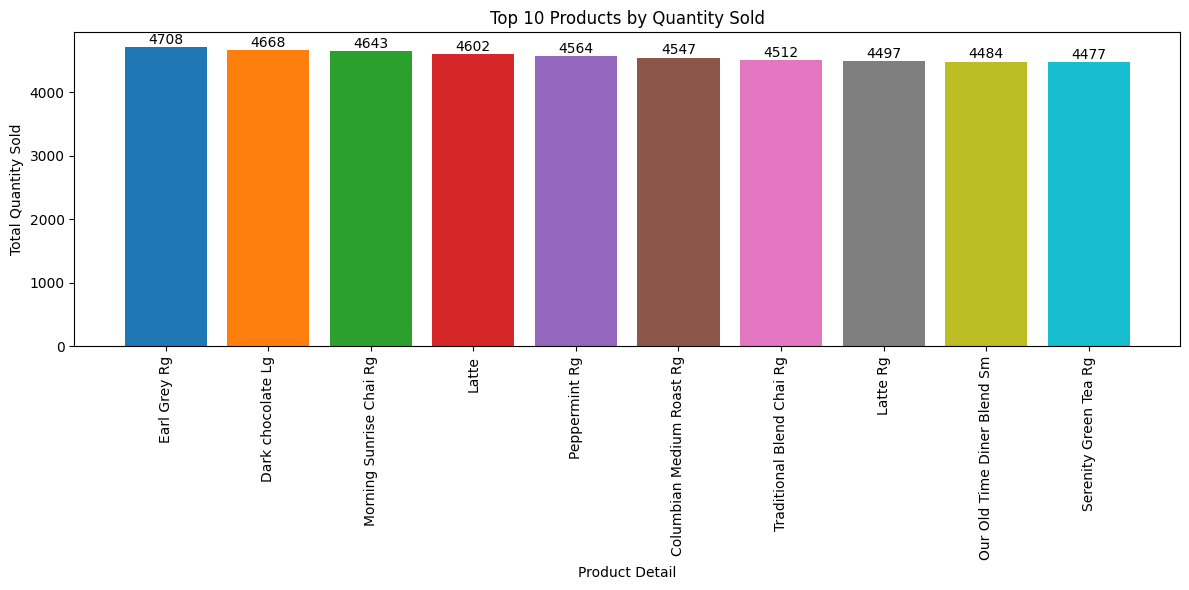

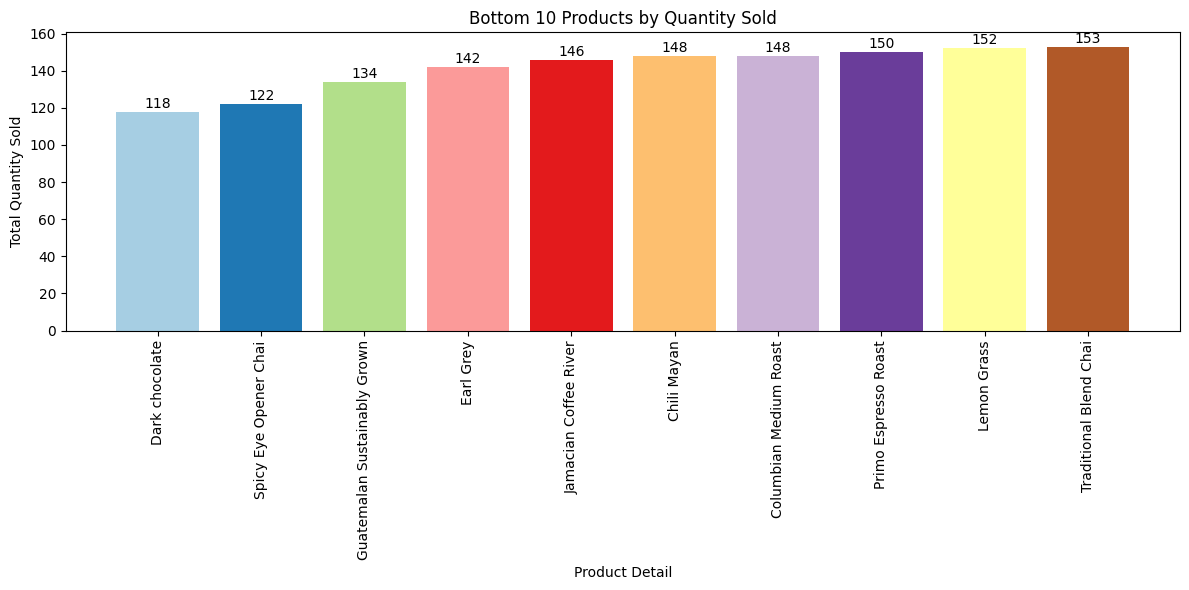

In [29]:
top_quantity_products = quantity_by_product.sort_values(by='transaction_qty', ascending=False).head(10)
low_quantity_products = quantity_by_product.sort_values(by='transaction_qty', ascending=True).head(10)
colors_top = plt.cm.tab10(np.linspace(0, 1, len(top_quantity_products)))
plt.figure(figsize=(12, 6))
bars_top = plt.bar(top_quantity_products['product_detail'], top_quantity_products['transaction_qty'], color=colors_top)
plt.xlabel('Product Detail')
plt.ylabel('Total Quantity Sold')
plt.title('Top 10 Products by Quantity Sold')
plt.xticks(rotation=90)
for bar in bars_top:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()
colors_low = plt.cm.Paired(np.linspace(0, 1, len(low_quantity_products)))
plt.figure(figsize=(12, 6))
bars_low = plt.bar(low_quantity_products['product_detail'], low_quantity_products['transaction_qty'], color=colors_low)
plt.xlabel('Product Detail')
plt.ylabel('Total Quantity Sold')
plt.title('Bottom 10 Products by Quantity Sold')
plt.xticks(rotation=90)
for bar in bars_low:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### 3.7 Correlation Analysis
- the correlations between key variables, such as unit price, transaction quantity, and
revenue, to identify relationships and dependencies among them.

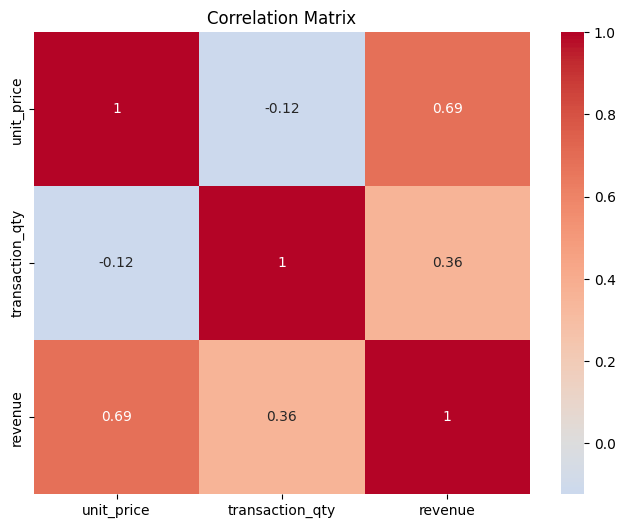

In [30]:
correlation_matrix = df[['unit_price', 'transaction_qty', 'revenue']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

##### 3.8 Customer Purchase Patterns
- Analyze customer purchasing behavior by examining transaction quantity per
transaction, highlighting key trends and patterns

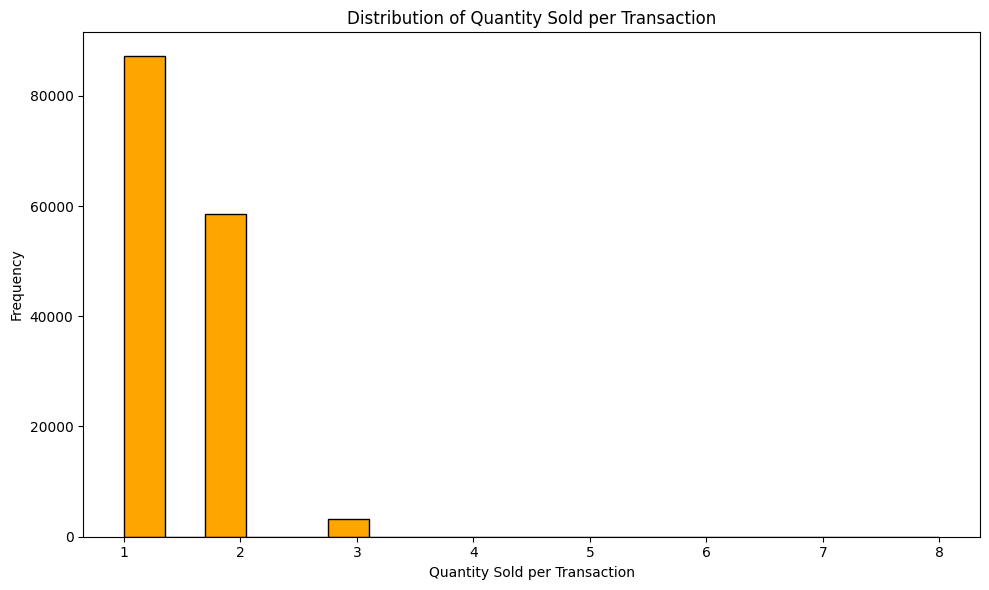

In [31]:
transaction_qty_per_transaction = df.groupby('transaction_id')['transaction_qty'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.hist(transaction_qty_per_transaction['transaction_qty'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Quantity Sold per Transaction')
plt.ylabel('Frequency')
plt.title('Distribution of Quantity Sold per Transaction')
plt.tight_layout()
plt.show()

#### 4. Profit Increase Prediction

##### 4.1 Trend Analysis Over Time
- Analyze and visualize how sales or revenue trends change over time.

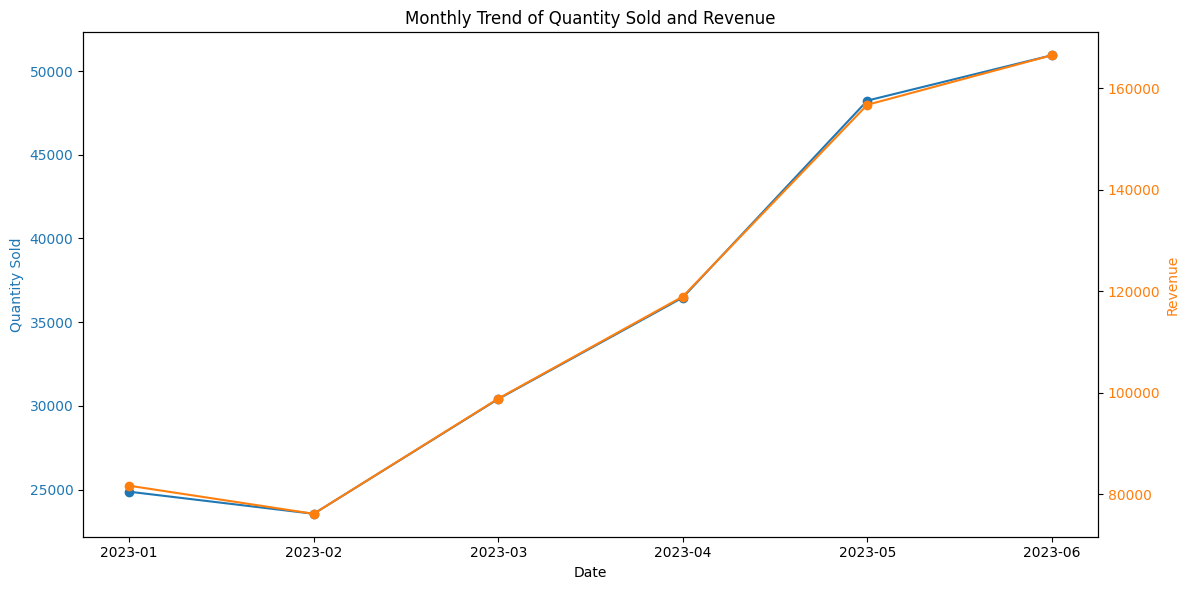

In [32]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
monthly_sales = df.groupby(df['transaction_date'].dt.to_period('M')).agg({
    'transaction_qty': 'sum',
    'revenue': 'sum'
}).reset_index()
monthly_sales['transaction_date'] = monthly_sales['transaction_date'].astype(str)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Quantity Sold', color='tab:blue')
ax1.plot(monthly_sales['transaction_date'], monthly_sales['transaction_qty'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Revenue', color='tab:orange')
ax2.plot(monthly_sales['transaction_date'], monthly_sales['revenue'], color='tab:orange', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.title('Monthly Trend of Quantity Sold and Revenue')
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

##### 4.2 Sales Performance by Time of Day
- Examine sales performance variations throughout different times of the day.


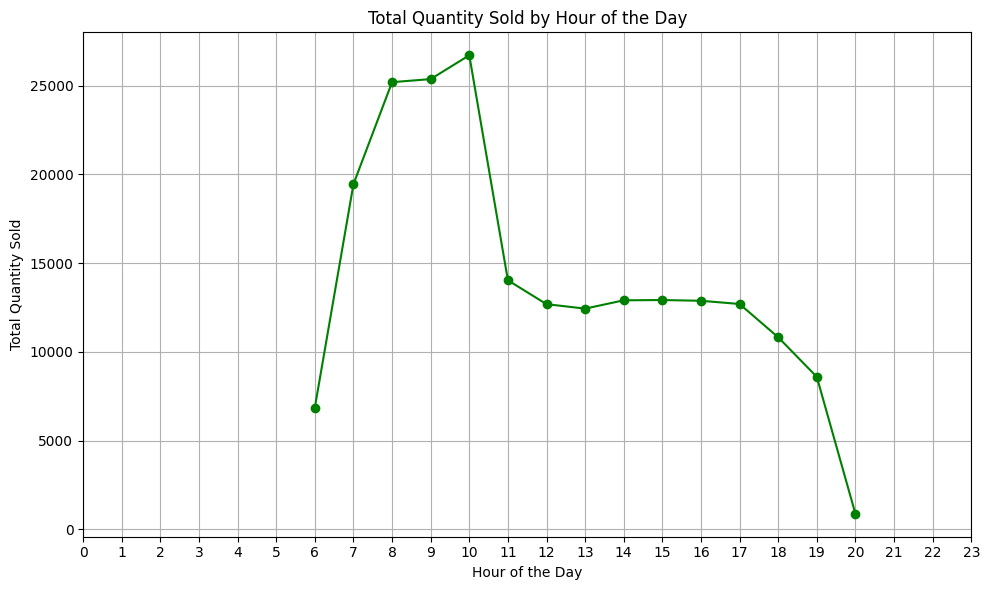

In [33]:
df['transaction_hour'] = df['transaction_time'].apply(lambda x: x.hour)
hourly_sales = df.groupby('transaction_hour')['transaction_qty'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(hourly_sales['transaction_hour'], hourly_sales['transaction_qty'], marker='o', linestyle='-', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Hour of the Day')
plt.xticks(range(24)) 
plt.grid(True)
plt.tight_layout()
plt.show()

##### 4.3 Forecasting with Random Forest

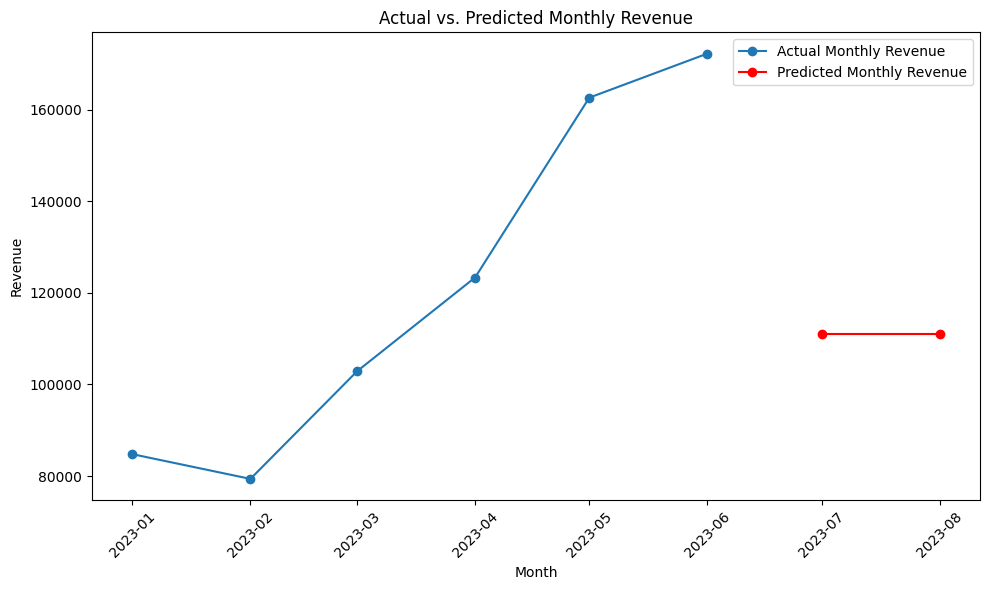

In [34]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
df_cleaned['month'] = df_cleaned['transaction_date'].dt.to_period('M').dt.to_timestamp()
monthly_data = df_cleaned.groupby('month').agg({
    'unit_price': 'mean',
    'transaction_qty': 'sum'
}).reset_index()
monthly_data['revenue'] = monthly_data['unit_price'] * monthly_data['transaction_qty']
X_revenue_monthly = monthly_data[['unit_price', 'transaction_qty']]
y_revenue_monthly = monthly_data['revenue']
X_train_revenue_monthly, X_test_revenue_monthly, y_train_revenue_monthly, y_test_revenue_monthly = train_test_split(
    X_revenue_monthly, y_revenue_monthly, test_size=0.2, shuffle=False
)

model_revenue_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
model_revenue_monthly.fit(X_train_revenue_monthly, y_train_revenue_monthly)
last_month = monthly_data['month'].iloc[-1]
future_months = [last_month + pd.DateOffset(months=i) for i in range(1, 3)]
future_features = pd.DataFrame({
    'unit_price': [monthly_data['unit_price'].mean()] * len(future_months),
    'transaction_qty': [monthly_data['transaction_qty'].mean()] * len(future_months)
})

future_revenue_pred = model_revenue_monthly.predict(future_features)
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['revenue'], label='Actual Monthly Revenue', marker='o')
plt.plot(future_months, future_revenue_pred, label='Predicted Monthly Revenue', color='red', marker='o')
plt.title('Actual vs. Predicted Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


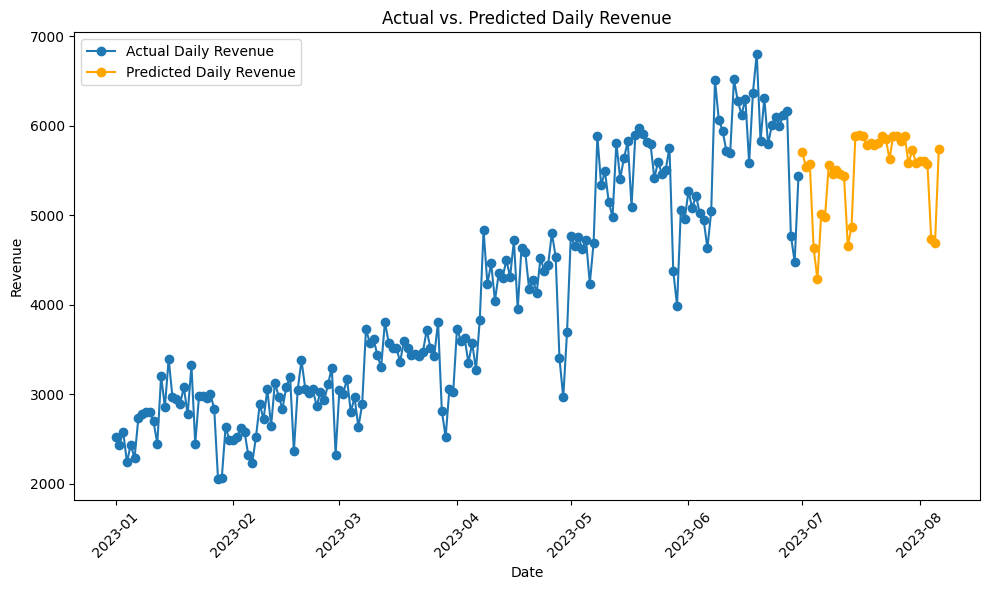

In [35]:
daily_data = df_cleaned.groupby('transaction_date').agg({
    'unit_price': 'mean',
    'transaction_qty': 'sum'
}).reset_index()

daily_data['revenue'] = daily_data['unit_price'] * daily_data['transaction_qty']

X_revenue_daily = daily_data[['unit_price', 'transaction_qty']]
y_revenue_daily = daily_data['revenue']

X_train_revenue_daily, X_test_revenue_daily, y_train_revenue_daily, y_test_revenue_daily = train_test_split(
    X_revenue_daily, y_revenue_daily, test_size=0.2, shuffle=False
)

model_revenue_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_revenue_daily.fit(X_train_revenue_daily, y_train_revenue_daily)

y_pred_revenue_daily = model_revenue_daily.predict(X_test_revenue_daily)

last_date = daily_data['transaction_date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, len(y_pred_revenue_daily) + 1)]

plt.figure(figsize=(10, 6))
plt.plot(daily_data['transaction_date'], daily_data['revenue'], label='Actual Daily Revenue', marker='o')
plt.plot(future_dates, y_pred_revenue_daily, label='Predicted Daily Revenue', color='orange', marker='o')
plt.title('Actual vs. Predicted Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

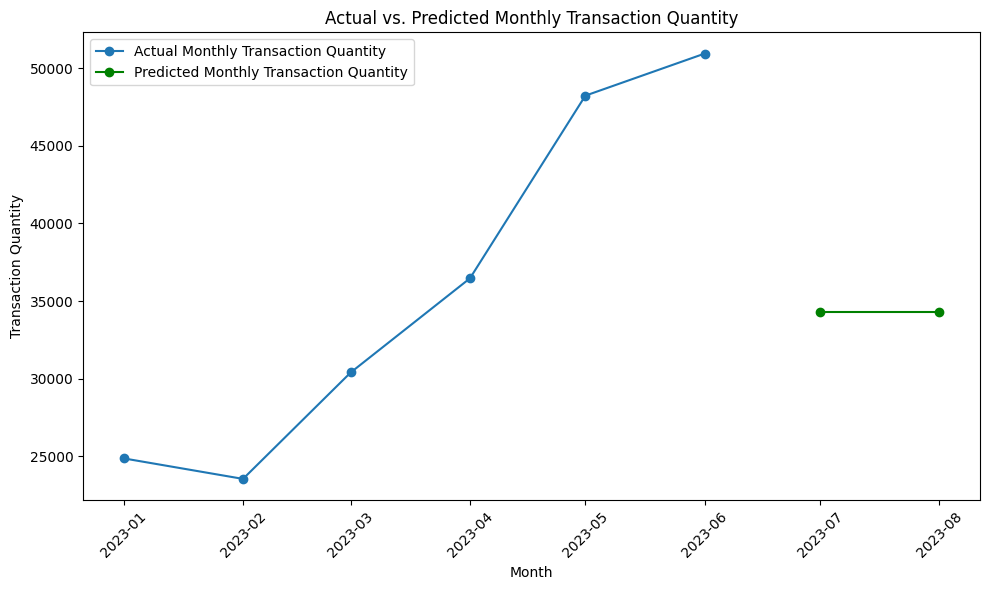

In [36]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
df_cleaned['month'] = df_cleaned['transaction_date'].dt.to_period('M').dt.to_timestamp()
monthly_data = df_cleaned.groupby('month').agg({'transaction_qty': 'sum'}).reset_index()
X_transaction_monthly = monthly_data[['transaction_qty']]
y_transaction_monthly = monthly_data['transaction_qty']

X_train_transaction_monthly, X_test_transaction_monthly, y_train_transaction_monthly, y_test_transaction_monthly = train_test_split(
    X_transaction_monthly, y_transaction_monthly, test_size=0.2, shuffle=False
)

model_transaction_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
model_transaction_monthly.fit(X_train_transaction_monthly, y_train_transaction_monthly)

y_pred_transaction_monthly = model_transaction_monthly.predict(X_test_transaction_monthly)

last_month = monthly_data['month'].iloc[-1]
future_months = [last_month + pd.DateOffset(months=i) for i in range(1, len(y_pred_transaction_monthly) + 1)]

plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['transaction_qty'], label='Actual Monthly Transaction Quantity', marker='o')
plt.plot(future_months, y_pred_transaction_monthly, label='Predicted Monthly Transaction Quantity', color='green', marker='o')
plt.title('Actual vs. Predicted Monthly Transaction Quantity')
plt.xlabel('Month')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

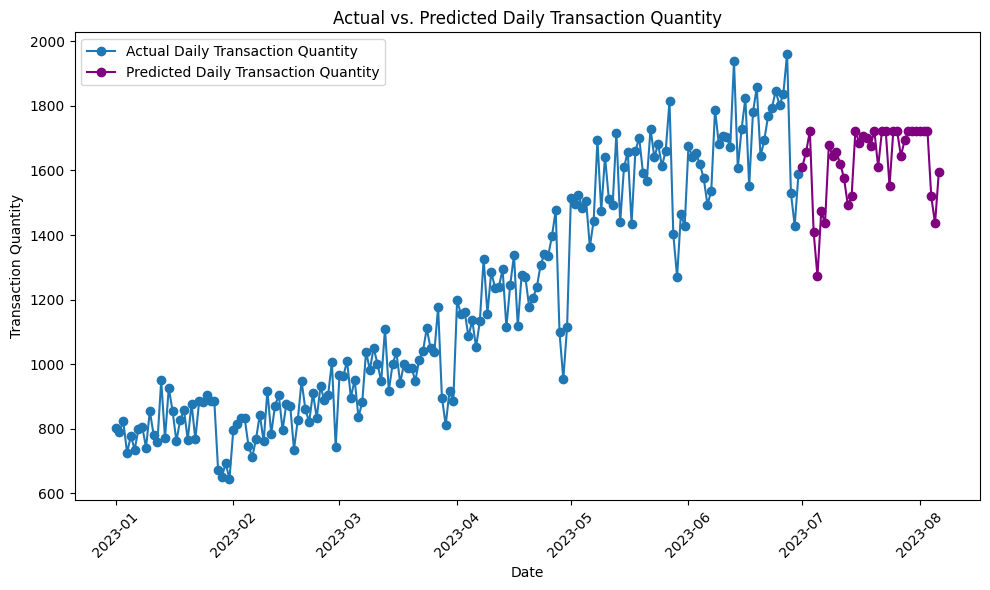

In [37]:
daily_data = df_cleaned.groupby('transaction_date').agg({'transaction_qty': 'sum'}).reset_index()

X_transaction_daily = daily_data[['transaction_qty']]
y_transaction_daily = daily_data['transaction_qty']

X_train_transaction_daily, X_test_transaction_daily, y_train_transaction_daily, y_test_transaction_daily = train_test_split(
    X_transaction_daily, y_transaction_daily, test_size=0.2, shuffle=False
)

model_transaction_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_transaction_daily.fit(X_train_transaction_daily, y_train_transaction_daily)

y_pred_transaction_daily = model_transaction_daily.predict(X_test_transaction_daily)

last_date = daily_data['transaction_date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, len(y_pred_transaction_daily) + 1)]

plt.figure(figsize=(10, 6))
plt.plot(daily_data['transaction_date'], daily_data['transaction_qty'], label='Actual Daily Transaction Quantity', marker='o')
plt.plot(future_dates, y_pred_transaction_daily, label='Predicted Daily Transaction Quantity', color='purple', marker='o')
plt.title('Actual vs. Predicted Daily Transaction Quantity')
plt.xlabel('Date')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 4.4 Forecasting with ARIMA

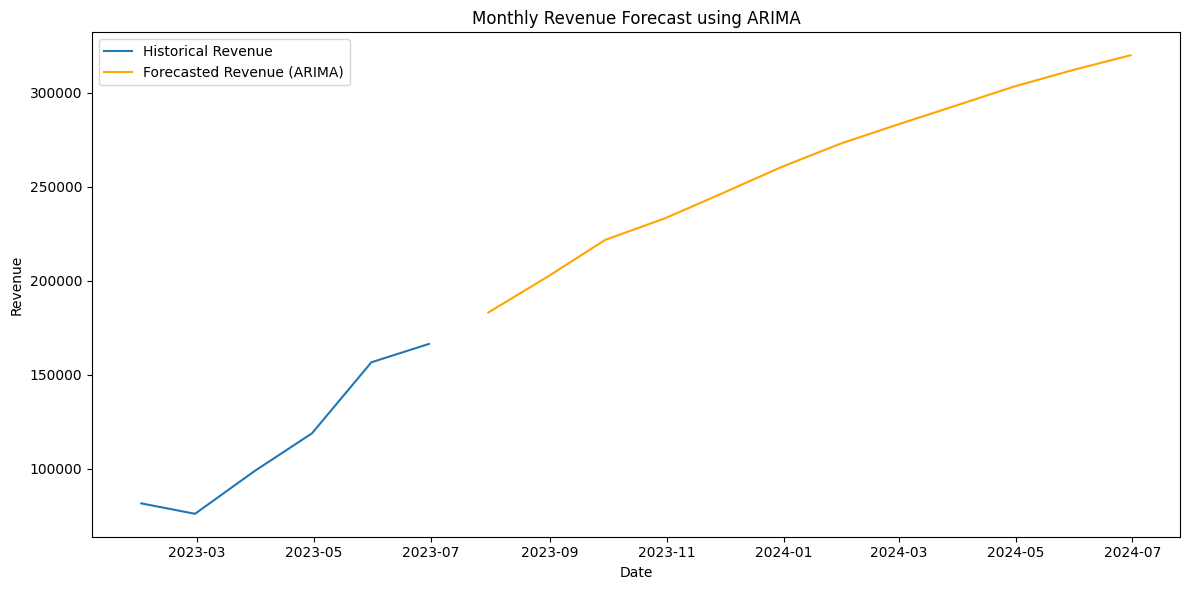

In [38]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
df_temp = df_cleaned.copy()
df_temp.set_index('transaction_date', inplace=True)
df_temp.sort_index(inplace=True)
time_series_data = (df_temp['transaction_qty'] * df_temp['unit_price']).resample('M').sum()
model_arima = ARIMA(time_series_data, order=(5, 1, 0))  # (p,d,q)
model_arima_fit = model_arima.fit()
forecast_steps = 12
forecast_arima = model_arima_fit.forecast(steps=forecast_steps)

forecast_index = pd.date_range(start=time_series_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

forecast_series = pd.Series(forecast_arima, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Historical Revenue')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Revenue (ARIMA)', color='orange')
plt.title('Monthly Revenue Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

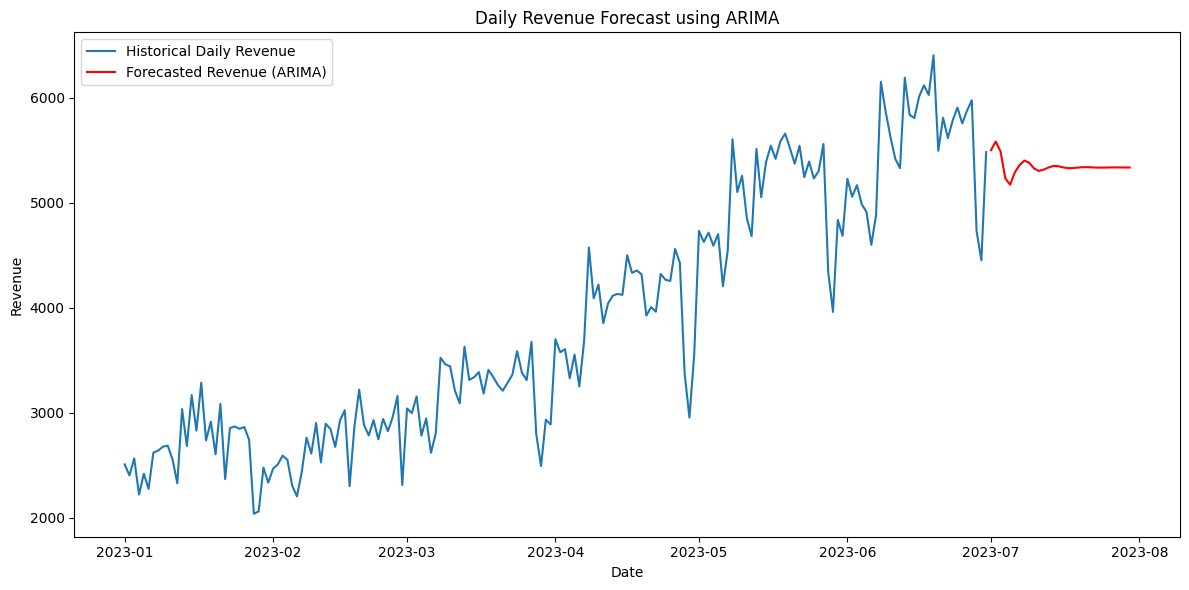

In [39]:
df_temp = df_cleaned.copy()
df_temp.set_index('transaction_date', inplace=True)
df_temp.sort_index(inplace=True)
time_series_data = (df_temp['transaction_qty'] * df_temp['unit_price']).resample('D').sum()
model_arima = ARIMA(time_series_data, order=(5, 1, 0))  # Example ARIMA(p,d,q)
model_arima_fit = model_arima.fit()
forecast_steps = 30
forecast_arima = model_arima_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=time_series_data.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D')
forecast_series = pd.Series(forecast_arima, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Historical Daily Revenue')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Revenue (ARIMA)', color='red')
plt.title('Daily Revenue Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

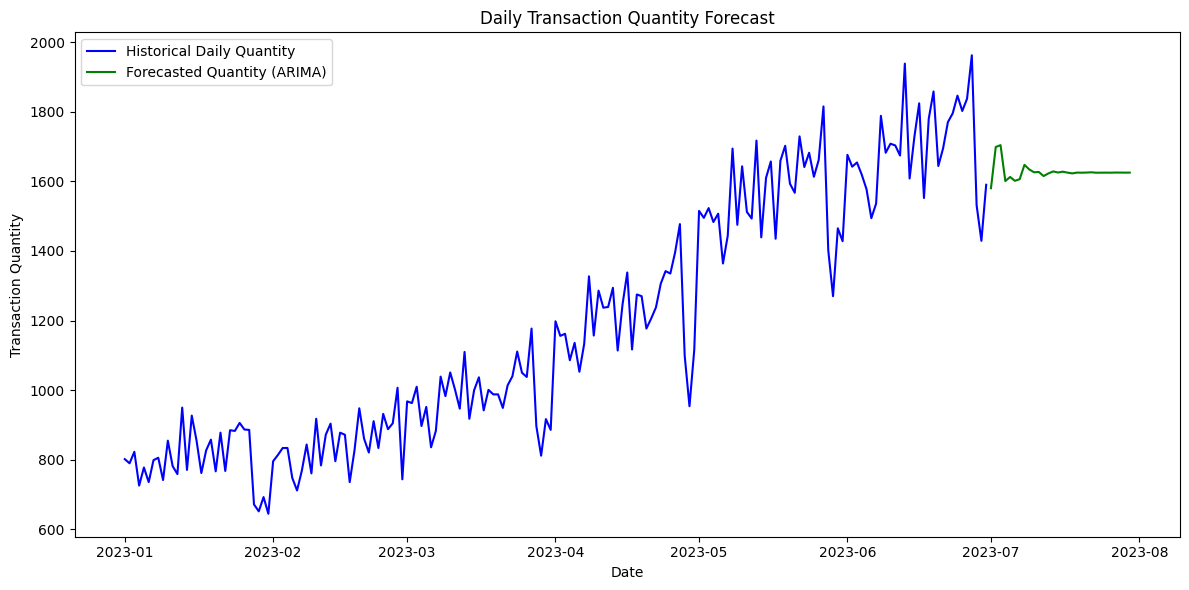

In [40]:
df_temp = df_cleaned.copy()
df_temp.set_index('transaction_date', inplace=True)
df_temp.sort_index(inplace=True)
time_series_data_daily = df_temp['transaction_qty'].resample('D').sum()
model_arima_daily = ARIMA(time_series_data_daily, order=(5, 1, 0))  # (p,d,q)
model_arima_fit_daily = model_arima_daily.fit()
forecast_steps_daily = 30
forecast_arima_daily = model_arima_fit_daily.forecast(steps=forecast_steps_daily)
forecast_index_daily = pd.date_range(
    start=time_series_data_daily.index[-1] + pd.DateOffset(days=1),
    periods=forecast_steps_daily,
    freq='D'
)

forecast_series_daily = pd.Series(forecast_arima_daily, index=forecast_index_daily)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data_daily.index, time_series_data_daily, label='Historical Daily Quantity', color='blue')
plt.plot(forecast_series_daily.index, forecast_series_daily, label='Forecasted Quantity (ARIMA)', color='green')
plt.title('Daily Transaction Quantity Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.tight_layout()
plt.show()

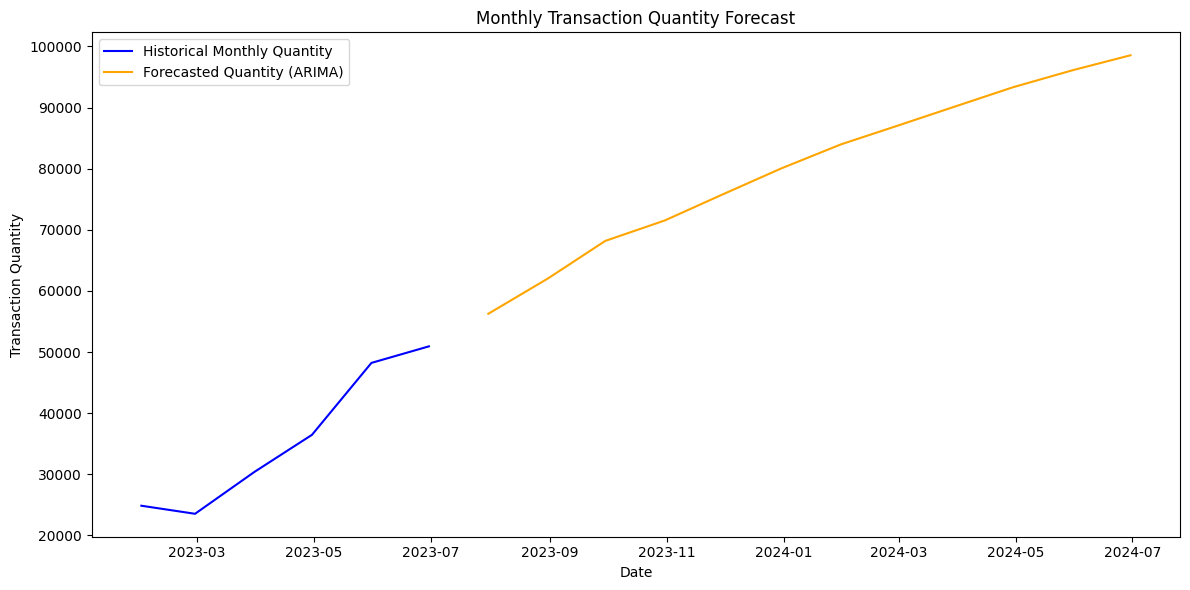

In [41]:
df_temp = df_cleaned.copy()
df_temp.set_index('transaction_date', inplace=True)
df_temp.sort_index(inplace=True)
time_series_data_monthly = df_temp['transaction_qty'].resample('M').sum()
model_arima_monthly = ARIMA(time_series_data_monthly, order=(5, 1, 0))
model_arima_fit_monthly = model_arima_monthly.fit()
forecast_steps_monthly = 12
forecast_arima_monthly = model_arima_fit_monthly.forecast(steps=forecast_steps_monthly)
forecast_index_monthly = pd.date_range(
    start=time_series_data_monthly.index[-1] + pd.DateOffset(months=1),
    periods=forecast_steps_monthly,
    freq='M'
)

forecast_series_monthly = pd.Series(forecast_arima_monthly, index=forecast_index_monthly)
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_monthly.index, time_series_data_monthly, label='Historical Monthly Quantity', color='blue')
plt.plot(forecast_series_monthly.index, forecast_series_monthly, label='Forecasted Quantity (ARIMA)', color='orange')
plt.title('Monthly Transaction Quantity Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.tight_layout()
plt.show()

##### 4.5 Forecasting with Prophet

19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:38 - cmdstanpy - INFO - Chain [1] done processing


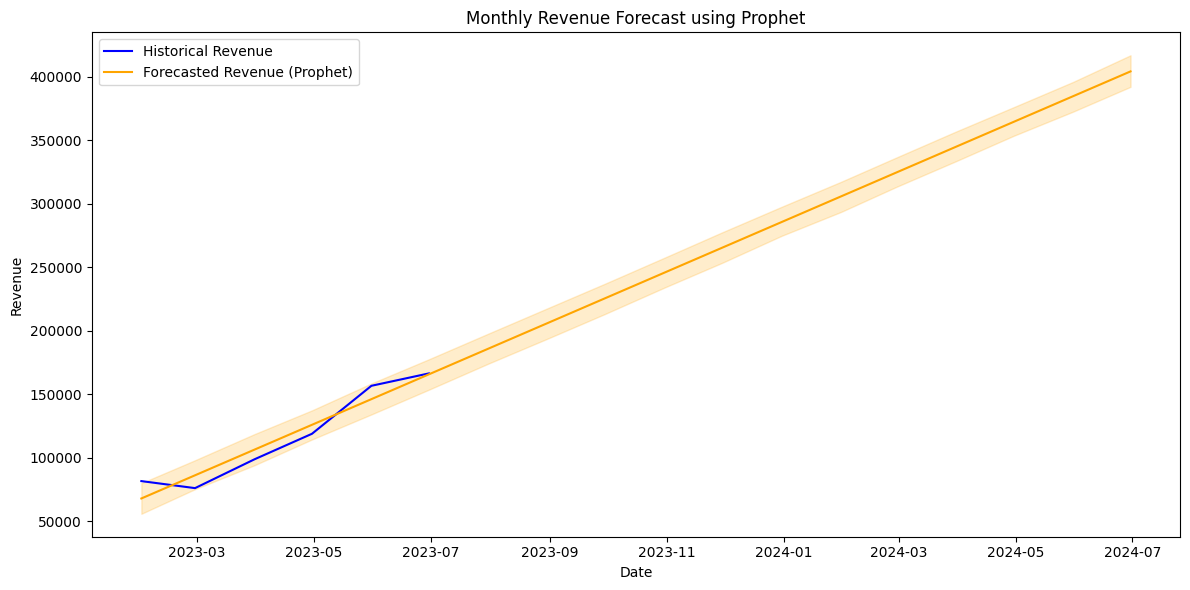

In [42]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
df_cleaned['revenue'] = df_cleaned['transaction_qty'] * df_cleaned['unit_price']
time_series_data = df_cleaned[['transaction_date', 'revenue']].resample('M', on='transaction_date').sum().reset_index()
time_series_data.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(time_series_data)
future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast = model_prophet.predict(future)
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['ds'], time_series_data['y'], label='Historical Revenue', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Revenue (Prophet)', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
plt.title('Monthly Revenue Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()


19:17:52 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing


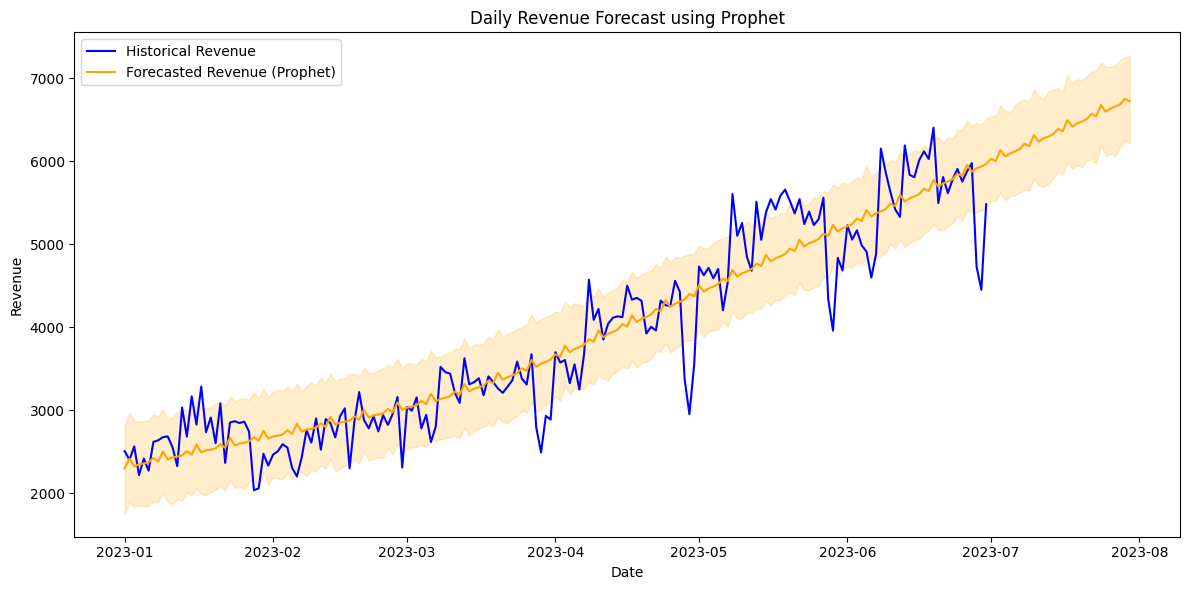

In [43]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
df_cleaned['revenue'] = df_cleaned['transaction_qty'] * df_cleaned['unit_price']
time_series_data = df_cleaned[['transaction_date', 'revenue']].resample('D', on='transaction_date').sum().reset_index()
time_series_data.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(time_series_data)
future = model_prophet.make_future_dataframe(periods=30, freq='D')
forecast = model_prophet.predict(future)
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['ds'], time_series_data['y'], label='Historical Revenue', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Revenue (Prophet)', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
plt.title('Daily Revenue Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:40 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:45 - cmdstanpy - INFO - Chain [1] done processing


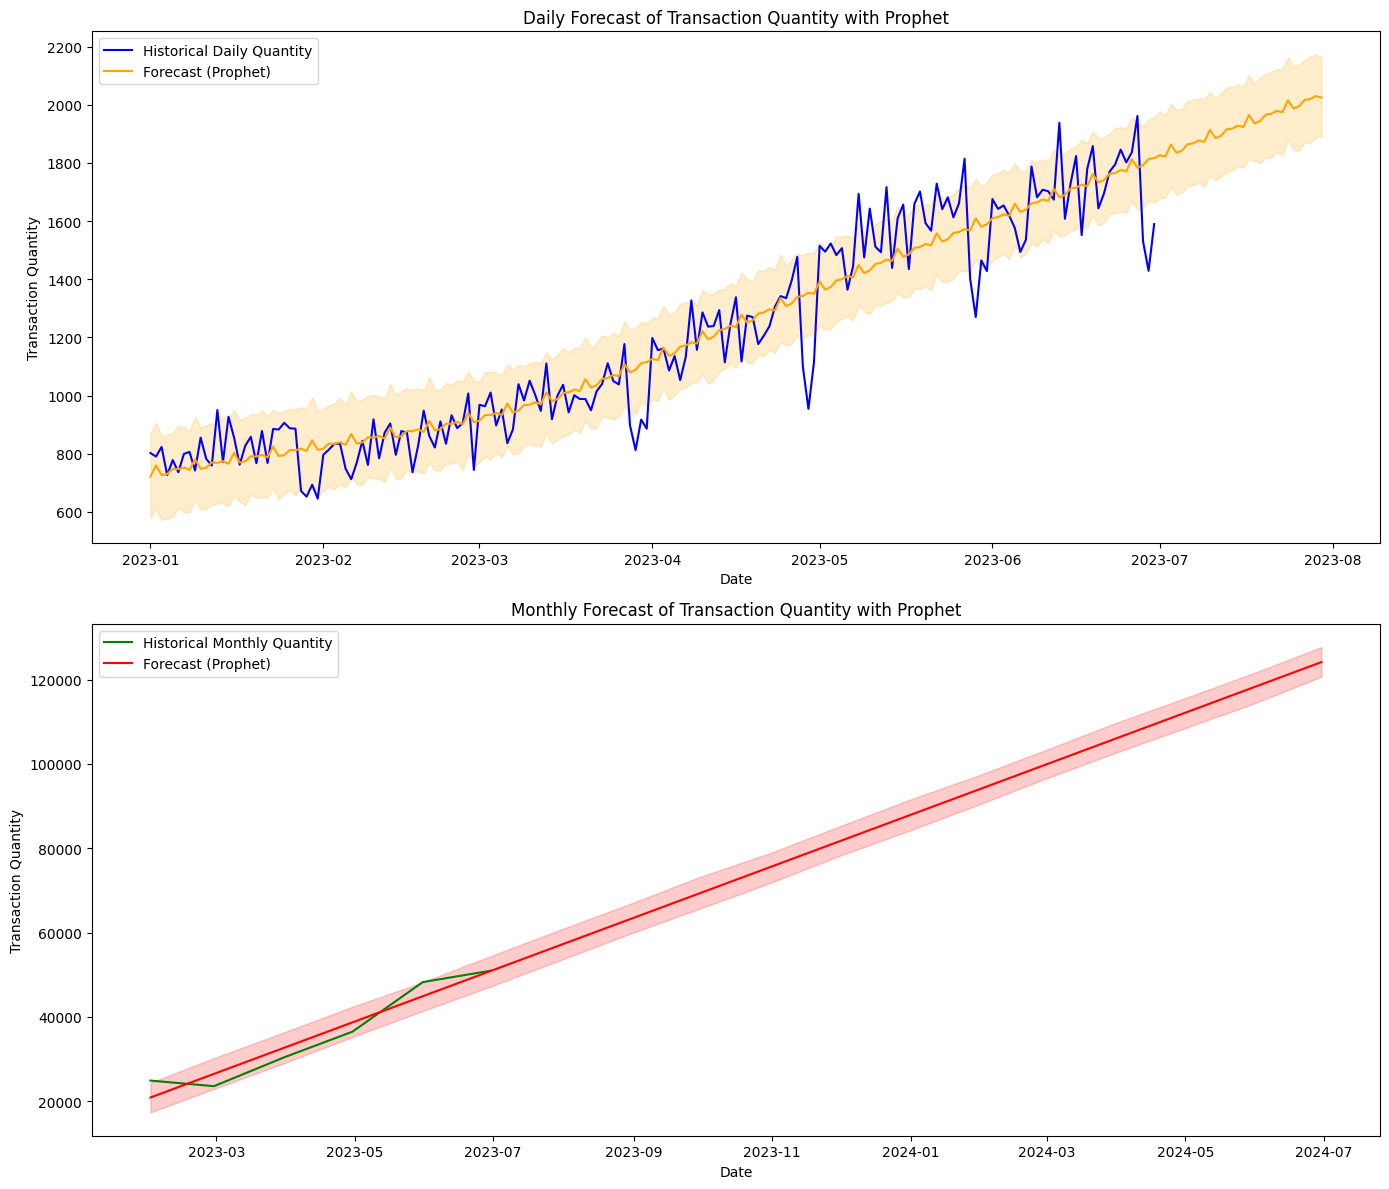

In [44]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
time_series_data_daily = df_cleaned[['transaction_date', 'transaction_qty']].resample('D', on='transaction_date').sum().reset_index()
time_series_data_daily.columns = ['ds', 'y']
model_prophet_daily = Prophet()
model_prophet_daily.fit(time_series_data_daily)
future_daily = model_prophet_daily.make_future_dataframe(periods=30, freq='D')
forecast_daily = model_prophet_daily.predict(future_daily)
time_series_data_monthly = df_cleaned[['transaction_date', 'transaction_qty']].resample('M', on='transaction_date').sum().reset_index()
time_series_data_monthly.columns = ['ds', 'y']
model_prophet_monthly = Prophet()
model_prophet_monthly.fit(time_series_data_monthly)
future_monthly = model_prophet_monthly.make_future_dataframe(periods=12, freq='M')
forecast_monthly = model_prophet_monthly.predict(future_monthly)
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 1)
plt.plot(time_series_data_daily['ds'], time_series_data_daily['y'], label='Historical Daily Quantity', color='blue')
plt.plot(forecast_daily['ds'], forecast_daily['yhat'], label='Forecast (Prophet)', color='orange')
plt.fill_between(forecast_daily['ds'], forecast_daily['yhat_lower'], forecast_daily['yhat_upper'], color='orange', alpha=0.2)
plt.title('Daily Forecast of Transaction Quantity with Prophet')
plt.xlabel('Date')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time_series_data_monthly['ds'], time_series_data_monthly['y'], label='Historical Monthly Quantity', color='green')
plt.plot(forecast_monthly['ds'], forecast_monthly['yhat'], label='Forecast (Prophet)', color='red')
plt.fill_between(forecast_monthly['ds'], forecast_monthly['yhat_lower'], forecast_monthly['yhat_upper'], color='red', alpha=0.2)
plt.title('Monthly Forecast of Transaction Quantity with Prophet')
plt.xlabel('Date')
plt.ylabel('Transaction Quantity')
plt.legend()
plt.tight_layout()
plt.show()

##### 4.6 products with the highest potential revenue increase

In [45]:
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'])
category_daily_revenue = df_cleaned.groupby(['transaction_date', 'product_category']).agg({
    'transaction_qty': 'sum',
    'unit_price': 'mean'
}).reset_index()
category_daily_revenue['revenue'] = category_daily_revenue['transaction_qty'] * category_daily_revenue['unit_price']
product_daily_revenue = df_cleaned.groupby(['transaction_date', 'product_detail']).agg({
    'transaction_qty': 'sum',
    'unit_price': 'mean'
}).reset_index()
product_daily_revenue['revenue'] = product_daily_revenue['transaction_qty'] * product_daily_revenue['unit_price']
def add_features(df):
    df['day_of_week'] = df['transaction_date'].dt.dayofweek
    df['month'] = df['transaction_date'].dt.month
    features = df[['unit_price', 'transaction_qty', 'day_of_week', 'month']]
    features = pd.get_dummies(features, drop_first=True)
    return features

category_features = add_features(category_daily_revenue)
category_target = category_daily_revenue['revenue']
product_features = add_features(product_daily_revenue)
product_target = product_daily_revenue['revenue']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(category_features, category_target, test_size=0.2, random_state=42)
X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(product_features, product_target, test_size=0.2, random_state=42)
model_cat = RandomForestRegressor(random_state=42)
model_cat.fit(X_train_cat, y_train_cat)
model_prod = RandomForestRegressor(random_state=42)
model_prod.fit(X_train_prod, y_train_prod)
category_daily_revenue['predicted_revenue'] = model_cat.predict(category_features)
product_daily_revenue['predicted_revenue'] = model_prod.predict(product_features)
category_daily_revenue['revenue_increase'] = category_daily_revenue['predicted_revenue'] - category_daily_revenue['revenue']
product_daily_revenue['revenue_increase'] = product_daily_revenue['predicted_revenue'] - product_daily_revenue['revenue']
positive_category_increase = category_daily_revenue[category_daily_revenue['revenue_increase'] > 0]
positive_product_increase = product_daily_revenue[product_daily_revenue['revenue_increase'] > 0]
top_categories = positive_category_increase.sort_values(by='revenue_increase', ascending=False).head(10)
print("Top Categories with Potential Revenue Increase:\n", top_categories[['product_category', 'revenue_increase']])
top_products = positive_product_increase.sort_values(by='revenue_increase', ascending=False).head(10)
print("\nTop Products with Potential Revenue Increase:\n", top_products[['product_detail', 'revenue_increase']])


Top Categories with Potential Revenue Increase:
      product_category  revenue_increase
1355              tea        125.456174
1093           coffee         47.856776
1117              tea         41.794145
1111           coffee         40.516056
1151              tea         38.664910
1310              tea         31.032704
327               tea         30.503207
233               tea         30.427650
1165           coffee         28.512911
216               tea         26.580878

Top Products with Potential Revenue Increase:
                     product_detail  revenue_increase
10945      i need my bean! t-shirt           44.3100
9346       i need my bean! t-shirt           25.6700
11334      i need my bean! t-shirt           16.6700
11492      i need my bean! t-shirt           15.4300
11697                  ethiopia lg           13.7025
10211  our old time diner blend sm            8.3850
7156     i need my bean! latte cup            7.9500
11851      i need my bean! t-shirt     

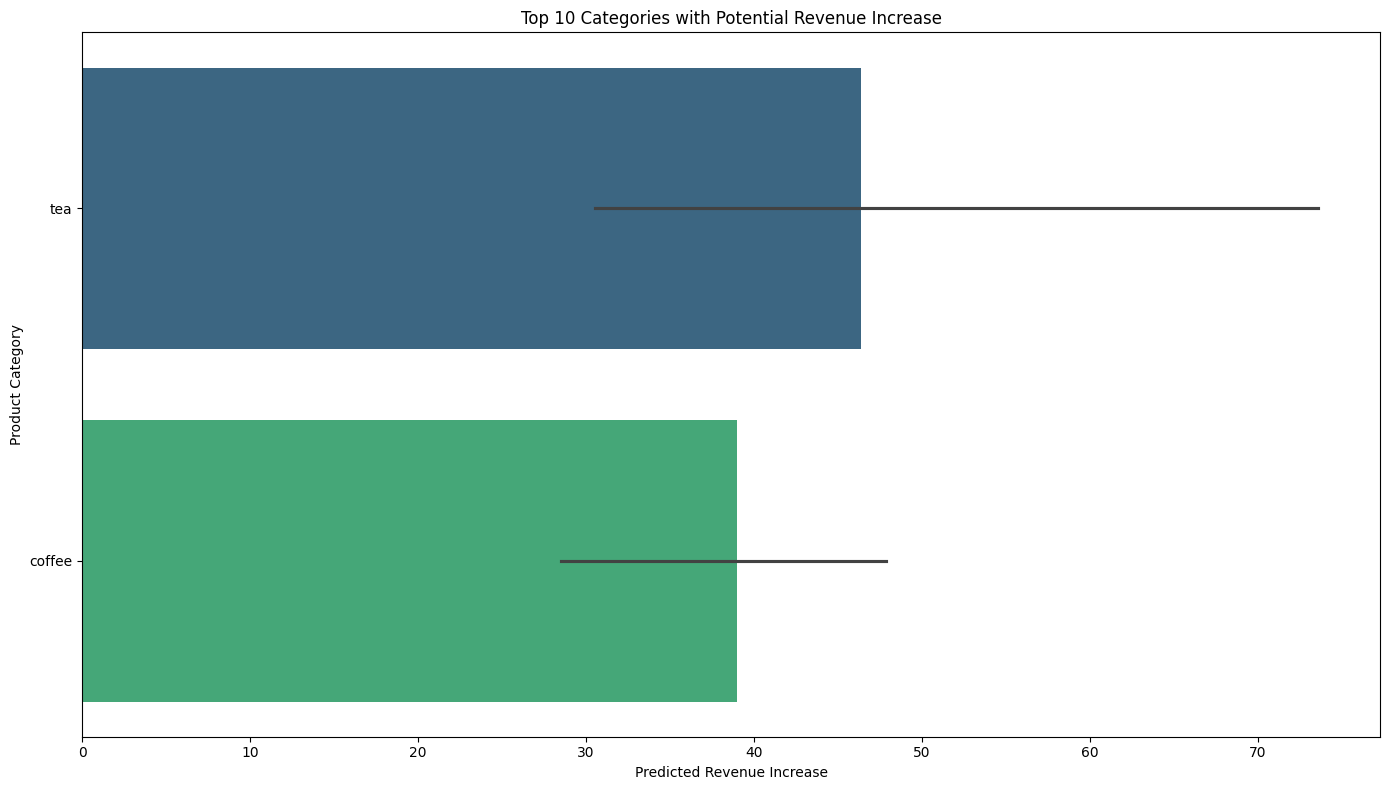

In [46]:
plt.figure(figsize=(14, 8))
sns.barplot(x='revenue_increase', y='product_category', data=top_categories.head(10), palette='viridis')
plt.title('Top 10 Categories with Potential Revenue Increase')
plt.xlabel('Predicted Revenue Increase')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

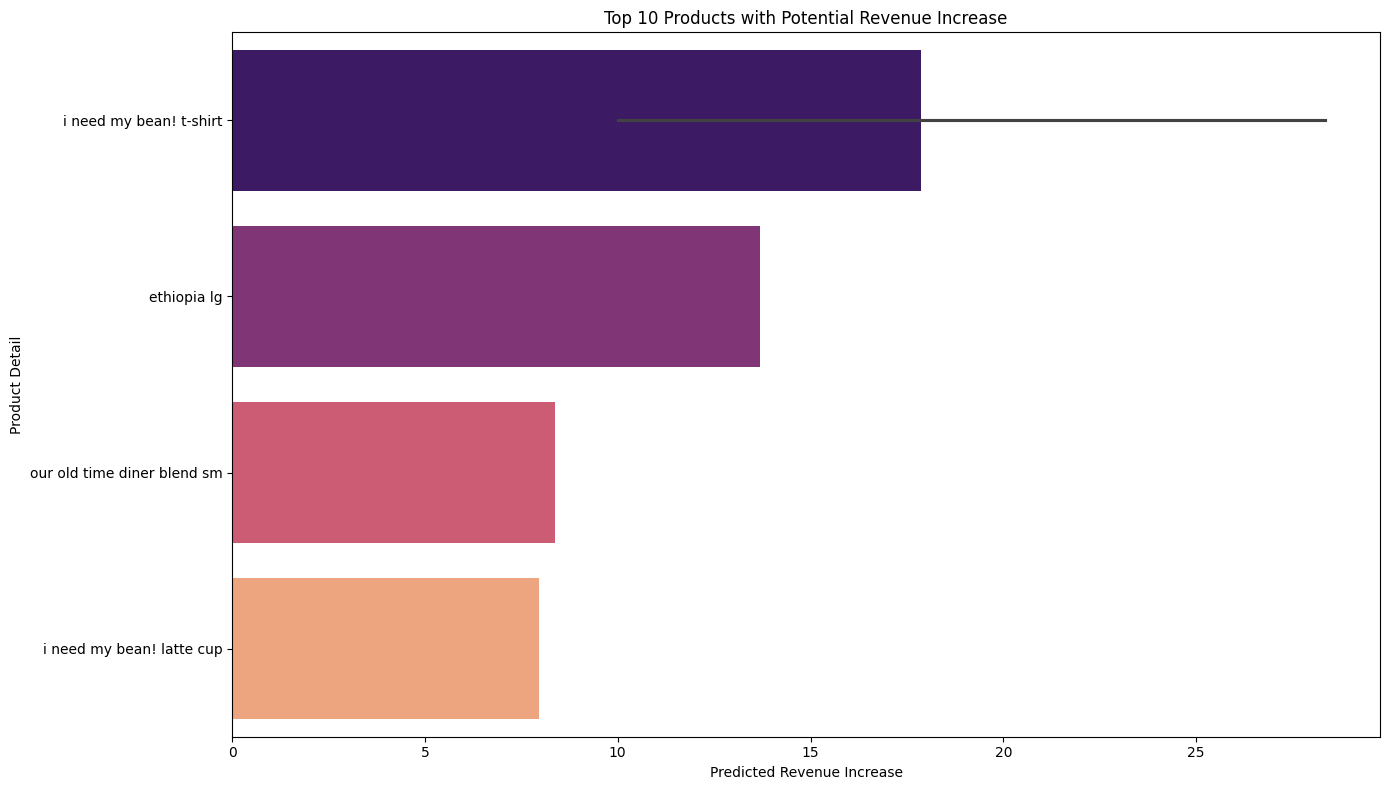

In [47]:
plt.figure(figsize=(14, 8))
sns.barplot(x='revenue_increase', y='product_detail', data=top_products.head(10), palette='magma')
plt.title('Top 10 Products with Potential Revenue Increase')
plt.xlabel('Predicted Revenue Increase')
plt.ylabel('Product Detail')
plt.tight_layout()
plt.show()

##### 4.7 Explore factors contributing to profitability.

In [48]:
df_cleaned['revenue'] = df_cleaned['unit_price'] * df_cleaned['transaction_qty']
X = df_cleaned[['unit_price', 'transaction_qty']]
y = df_cleaned['revenue']  
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.043e+05
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:22:22   Log-Likelihood:            -2.8779e+05
No. Observations:              119292   AIC:                         5.756e+05
Df Residuals:                  119289   BIC:                         5.756e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.5934      0.025   -1

**Interpretation:**
- The OLS regression results indicate a significant relationship between revenue and the
factors of unit price and transaction quantity. The model, with an R-squared value of
0.636, shows that both unit price and transaction quantity are strong predictors of
revenue, with coefficients suggesting that increases in either factor are associated with
higher revenue. The statistical significance of these predictors (p-values < 0.05) confirms
their substantial impact on profitability.


#### 5. Loss Mitigation Analysis

##### 5.1. Factors Contributing to Losses
Products/Services with Low Sales Volume

In [49]:
low_sales_products = df_cleaned.groupby('product_detail').agg({
    'transaction_qty': 'sum',
    'revenue': 'sum'
}).reset_index()
low_sales_threshold = low_sales_products['transaction_qty'].quantile(0.1)

low_sales_products = low_sales_products[low_sales_products['transaction_qty'] <= low_sales_threshold]
print(low_sales_products[['product_detail', 'transaction_qty', 'revenue']])

                  product_detail  transaction_qty  revenue
8                    chili mayan              148  1972.84
13        columbian medium roast              148  2220.00
19                dark chocolate              118   755.20
22                     earl grey              142  1270.90
36  guatemalan sustainably grown              134  1340.00
42         jamacian coffee river              146  2883.50
65          primo espresso roast              150  3067.50
70         spicy eye opener chai              122  1335.90


Products/Services with Low Revenue Generation

In [50]:
low_revenue_threshold = low_sales_products['revenue'].quantile(0.1)
low_revenue_products = low_sales_products[low_sales_products['revenue'] <= low_revenue_threshold]
print(low_revenue_products[['product_detail', 'transaction_qty', 'revenue']])

    product_detail  transaction_qty  revenue
19  dark chocolate              118    755.2


Factors


- **Factor 1:** Low sales volume indicating poor market demand or ineffective marketing.
- **Factor 2:** Low revenue generation suggesting insufficient pricing strategy or product
appeal.

##### 5.2. Develop strategies to minimize or eliminate losses.
1. Strategy: Identify and Promote Low-Selling Products

In [54]:
low_sales = df_cleaned.groupby('product_detail').agg({
 'transaction_qty': 'sum',
 'revenue': 'sum'
}).sort_values(by='transaction_qty').head(10)
print("Products with Low Sales Volume:")
print(low_sales)

Products with Low Sales Volume:
                              transaction_qty  revenue
product_detail                                        
dark chocolate                            118   755.20
spicy eye opener chai                     122  1335.90
guatemalan sustainably grown              134  1340.00
earl grey                                 142  1270.90
jamacian coffee river                     146  2883.50
chili mayan                               148  1972.84
columbian medium roast                    148  2220.00
primo espresso roast                      150  3067.50
lemon grass                               152  1360.40
traditional blend chai                    153  1369.35


**Suggestion:**
- Targeted marketing campaigns for these low-selling products to increase their market
demand.
- Offer discounts or promotions to incentivize purchases.
- Investigate the quality or packaging of these products to improve their market appeal.
- Collect customer feedback to understand why these products are underperforming.


2. Strategy: Adjust Pricing for Low Revenue Products

In [55]:
low_revenue = df_cleaned.groupby('product_detail').agg({
 'transaction_qty': 'sum',
 'revenue': 'sum'
}).sort_values(by='revenue').head(10)
print("\nProducts with Low Revenue Generation:")
print(low_revenue)


Products with Low Revenue Generation:
                              transaction_qty  revenue
product_detail                                        
dark chocolate                            118   755.20
earl grey                                 142  1270.90
spicy eye opener chai                     122  1335.90
guatemalan sustainably grown              134  1340.00
lemon grass                               152  1360.40
peppermint                                153  1369.35
traditional blend chai                    153  1369.35
english breakfast                         161  1440.95
serenity green tea                        159  1470.75
morning sunrise chai                      168  1596.00


**Suggestion:**
- Reevaluate pricing strategies for these products to make them more appealing.
- Consider bundling these with popular products to increase overall sales.

3. Strategy: Cross-Promote or Improve Quality of Low-Performing Products

In [56]:
low_performance = df_cleaned.groupby('product_detail').agg({
 'transaction_qty': 'sum',
 'revenue': 'sum'
}).sort_values(by=['transaction_qty', 'revenue']).head(10)
print("\nLow-Performing Products (Low Sales & Low Revenue):")
print(low_performance)



Low-Performing Products (Low Sales & Low Revenue):
                              transaction_qty  revenue
product_detail                                        
dark chocolate                            118   755.20
spicy eye opener chai                     122  1335.90
guatemalan sustainably grown              134  1340.00
earl grey                                 142  1270.90
jamacian coffee river                     146  2883.50
chili mayan                               148  1972.84
columbian medium roast                    148  2220.00
primo espresso roast                      150  3067.50
lemon grass                               152  1360.40
peppermint                                153  1369.35


**Suggestion:**
- Cross-promote these low-performing products with bestsellers to boost their sales.
- Investigate the quality or packaging of these products to improve their market appeal.
- Collect customer feedback to understand why these products are underperforming.


##### 5.3. Actionable steps to convert loss-making products/services into profitable ones.


In [58]:
from IPython.display import display, Markdown
loss_making_products = df_cleaned.groupby('product_detail').agg({
 'transaction_qty': 'sum',
 'revenue': 'sum'
}).sort_values(by=['revenue', 'transaction_qty']).head(10)
display(Markdown("##### Loss-Making Products (Low Sales & Low Revenue):"))
print(loss_making_products)
actionable_steps = {
 "Enhance Marketing and Promotion": "Invest in digital marketing, offer discounts or bundles.",

 "Reevaluate Pricing Strategy": "Ensure competitive pricing, consider  price adjustments.",
 "Improve Product Quality or Packaging": "Collect feedback, redesign packaging.",
 "Cross-Sell or Bundle with Popular Products": "Create bundles, offer cross-selling opportunities.",

 "Explore Alternative Sales Channels": "Expand sales channels, partner with influencers",
}
display(Markdown("#### Actionable Steps to Convert Loss-Making Products into Profitable Ones"))
for step, description in actionable_steps.items():
 display(Markdown(f"- **{step}**: {description}"))

##### Loss-Making Products (Low Sales & Low Revenue):

                              transaction_qty  revenue
product_detail                                        
dark chocolate                            118   755.20
earl grey                                 142  1270.90
spicy eye opener chai                     122  1335.90
guatemalan sustainably grown              134  1340.00
lemon grass                               152  1360.40
peppermint                                153  1369.35
traditional blend chai                    153  1369.35
english breakfast                         161  1440.95
serenity green tea                        159  1470.75
morning sunrise chai                      168  1596.00


#### Actionable Steps to Convert Loss-Making Products into Profitable Ones

- **Enhance Marketing and Promotion**: Invest in digital marketing, offer discounts or bundles.

- **Reevaluate Pricing Strategy**: Ensure competitive pricing, consider  price adjustments.

- **Improve Product Quality or Packaging**: Collect feedback, redesign packaging.

- **Cross-Sell or Bundle with Popular Products**: Create bundles, offer cross-selling opportunities.

- **Explore Alternative Sales Channels**: Expand sales channels, partner with influencers